In [1]:
"""
Runs DDD model either in single run model or for calibration- March 10.03.2023
The model itself is called as a function which calls on several functions
-This version (March 10.03.2023) includes an option for estimating MAD from catchment characteristics if
the catchmnet contains glaciers (since MAD is used to estimate subsurface capacity, runoff from glaciers implies
an observed MAD is an overestimation). The delay and dampening caused by lakes are represented by 
a normally distributed UH after the river UH
"""

using CSV
using Distributions
using LsqFit
using Statistics
using Dates
using DataFrames
using BlackBoxOptim
using Plots

#Preprocessing routines
include("\\petr\\DDDFunctions\\Big2SmallLambda.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\CeleritySubSurface.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SingleUH.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SingleNormalUH.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\LayerEstimation.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\PyrAreas.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\TemperatureVector.jl")
#EB and Snow Routines
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\NedbEBGlac_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SnowpackTemp.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SmeltEBGlac_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\CloudCoverGlac_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\TssDewpoint.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SolradTransAlbedoper_hrs_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\LongWaveRad_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SensibleLatHeat_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\AlbedoUEB_debug04072022.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\GroundPrecCC.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SnowGamma.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\Varc.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\NewSnowDensityEB.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\NewSnowSDEB.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\DensityAge.jl")
# Subsurface and Evaporation routines
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\LayerCapacityUpdate.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\PotentialEvapPT.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\UnsaturatedEvapEB.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\LayerEvap.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\UnsaturatedExEvap.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\WetlandsEB.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\GrvInputDistribution.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\LayerUpdate.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\BogLayerUpdate.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\RiverUpdate.jl")
# Overland Flow routine
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\OverlandFlowDynamicDD.jl")
# Efficiency criteria
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\NSEJM.jl")
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\KGEJM.jl")
# Model Module
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\DDDModulFunc-MAD-LAKE.jl")
#################################################################################################################

stfil = "\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_kalibrering\\Julia\\vf_liste.csv"
st = CSV.read(stfil,DataFrame,header=["Name"])

for i in 64:64 #length(st.Name) # calibration loops 74 er Sula 125 er 203.2 Jægervatn
catchment = st.Name[i] #"55.4"

if i == 17
    catchment ="6.10"
end   
if i==23
    catchment = "12.150"
end
if i == 21
    catchment ="12.70"
end 
if i == 39
    catchment ="16.140"
end 
if i == 41
    catchment ="18.10"
end 
if i == 52
    catchment ="26.20"
end 
if i == 70
    catchment ="62.10"
end 
if i == 83
   catchment ="87.10"
end  
if i == 89
    catchment ="103.40"
end
if i == 97
    catchment ="121.20"
end 
if i == 111
    catchment ="156.10"
end
if i == 128
    catchment ="212.10"
end 
if i == 135
    catchment ="311.460"
end 
if i == 136
    catchment ="313.10"
end    

    
TR = "3h"
    
ptqfile = string("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDD3h\\inndataV2\\",catchment,"\\",
        catchment,"_",TR,"_ptq_SN2018_kal.csv")    
    
r2fil = string("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_kalibrering\\Julia\\utdata2018EBlaketest\\r2fil_",
        catchment,"_test.csv")
    
utfile = string("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_kalibrering\\Julia\\utdata2018EBlaketest\\",
        "simres_kal_EB_",catchment,"_",TR,".csv")    
    
paramfile = string("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_kalibrering\\Julia\\LakeTestSN2018EB\\",
        "Test_par_",catchment,"_",TR,".csv")     
    
    prm = CSV.read(paramfile,DataFrame,header=["Name", "val"])
# Parameters to be calibrated
#      pkr,          skr,         u,           pro,         TX,          a0,       CX,    rv, GshInt, GscInt, TS
tprm = [prm.val[17], prm.val[18], prm.val[19], prm.val[20], prm.val[21], prm.val[23], prm.val[25], 
        prm.val[40],prm.val[38],prm.val[39], prm.val[26]]

println(catchment)    

Gshape, Gscale = Big2SmallLambda(prm.val[38], prm.val[39]) # Coverting integrated celerity to layers takes to long in calibration: preprocessing
Gpar = [Gshape, Gscale]
#println(Gpar)
println("GshInt, GscInt, dmid ",prm.val[38]," ", prm.val[39]," ",prm.val[45]) # GshInt, GscInt, dmid)    

startsim = 1
kal = 0
modstate = 0
savestate = 0

t1= time_ns()

function calib_wrapper_model(Gpar,startsim, tprm, prm, ptqfile, utfile, r2fil, modstate, savestate,catchment, kal)
 qobs, qberegn, KGE, NSE, bias = DDDModulFunc(Gpar,startsim, tprm, prm, ptqfile, utfile, r2fil, modstate, savestate,catchment,kal)  
 return qobs,qberegn, KGE,NSE,bias 
end

function calib_single_wsh(Gpar,startsim, tprm, prm, ptqfile, utfile, r2fil, modstate, savestate, catchment, kal)
 qobs, qberegn, KGE, NSE, bias = DDDModulFunc(Gpar,startsim, tprm, prm, ptqfile, utfile, r2fil, modstate, savestate,catchment,kal)    
 return (1.0 - KGE)
 #return abs(1.0 - bias)      
end

if(kal == 0)
    qobs,qberegn,KGE,NSE, bias = calib_wrapper_model(Gpar,startsim, tprm, prm, ptqfile, utfile, r2fil,
                                           modstate, savestate,catchment, kal) # a single run 
    println("KGE=",round(KGE,digits=3))
    println("NSE=",round(NSE,digits=3))
    println("bias=",round(bias,digits=3))
end


if(kal == 1) # calibrate
    #               pkr,      skr,      u,         pro,       TX,        a0,    cx,   rv,       GshInt,   GscInt, TS
    #param_range = [(0.5,2.5),(0.5,2.5),(0.5,3.5), (0.01,0.1),(-2.0,2.0),(5.5,5.5),(2.0,5.0),(0.5,2.5),(0.8,2.5),(0.01,0.4)]
    param_range = [(0.5,2.0),(0.5,1.5),(1.0,4.0), (0.01,0.1),(-2.0,2.0),(1,50.0),(0.0, 0.0),
            (0.4,3.0),(tprm[9],tprm[9]),(tprm[10],tprm[10]), (0.0, 0.0)]
    #param_range = [(0.5,2.0),(tprm[2],tprm[2]),(tprm[3],tprm[3]), (tprm[4],tprm[4]),(tprm[5],tprm[5]),(tprm[6],tprm[6]),(tprm[7],tprm[7]),
    #       (tprm[8],tprm[8]),(tprm[9],tprm[9]),(tprm[10],tprm[10])]    
    println(param_range)
    calib_single_wsh_tmp(param) = calib_single_wsh(Gpar,startsim, param, prm, ptqfile, utfile, r2fil,
                                           modstate, savestate,catchment, kal)
    res = bboptimize(calib_single_wsh_tmp; SearchRange = param_range, MaxSteps = 1000, TraceMode = :verbose)
    param_hydro = best_candidate(res)
#     println(param_hydro)
end
    

println(catchment)    
println("Pkorr=", round(tprm[1],digits=3))
t2 = time_ns()
    
println("Time elapsed[s]= ",(t2-t1)/1.0e9)
    BogLayers[nodaysvector] = 0.0
end # calibration loopend # calibration loop

# 
if(kal == 0)
 plot!(qberegn[500:1000])
end    

48.5
GshInt, GscInt, dmid 1.0 0.01 148.0
nodaysLake=9
M=398.908
KGE=0.901
NSE=0.809
bias=1.004
48.5
Pkorr=1.018
Time elapsed[s]= 44.029271501


UndefVarError: [91mUndefVarError: BogLayers not defined[39m

5


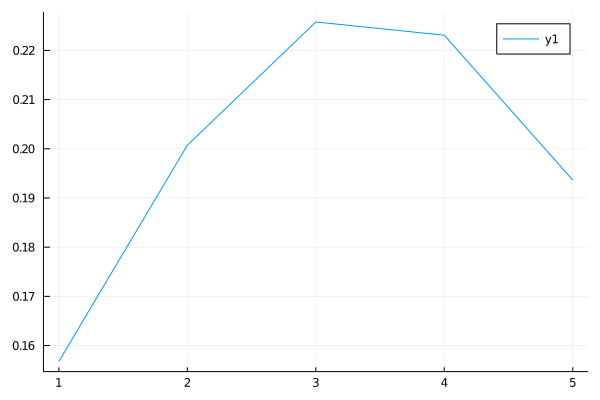

In [229]:
using Distributions
using Statistics
using Plots
include("\\\\nve.no\\fil\\h\\HB\\HB-modellering\\DDDtestbenk\\DDD_Julia\\DDDFunctions\\SingleNormalUH.jl")

Lv = 0.2
Timeresinsec = 10800
midLake = 5200.0
stdLake =6000.0
maxLake = 10000.0
UHLake, noDLake, nodaysLake = SingleNormalUH(Lv,Timeresinsec,midLake,stdLake,maxLake) #This subroutine extracts a UH normally distributed.
println(nodaysLake)
plot(UHLake)